<a href="https://colab.research.google.com/github/AShipulin/Train-Scheduler-Simulator-SimPy/blob/main/TrainSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# График движения поездов

## Функционал

Реализовано:

- v.1 построение графика движения поездов на однопутном участке
  - Интервал скрещения поездов
  - Интервал попутного отправления
  - Интервал попутного прибытия
  - Обгоны поездов

Ожидается:

- v.4 добавлена совместимость программой визуализации графика движения поездов
- Время хода между станциями
- Время на разгон
- Время на замедление
- Полуавтоблокировка
- Двухпутный и многопутные участки
- Дифиренсацию интервала для разных категорий поездов
- Количество путей на станции для четных / нечетных поездов
- Занятость путей станции

## Описание модели

График движения поездов строится с использованием дискретно-событийного имитационного моделирования.
Для построения используется библиотека имитационного моделирования SimPy.
Существующие ресурсы PriorityResource, PreemptiveResource а так-же вытеснение ресурсов,
позволяет построить график движения поездов технологически корректный.


## Источники

Используемые ресурсы:

- https://simpy.readthedocs.io/en/latest/
- https://pypi.org/project/simpy/
- https://gitlab.com/team-simpy/simpy/

Примеры моделей:

- https://github.com/sisl/event-driven-rllab/blob/932d6cc0911071443d1d43277ee011f4d832631e/FirestormProject/OldEnvs/traffic_light_env.py#L99

## Постановка задачи

Структура график движения представляется виде графа
- узлы (вершины) которого представляют станции
- дуги (ребра) которого представляют пути между станциями

Ориентированный граф (от англ. digraph)

$$D = (V,A)$$ (1)

где
- $V = \{v_1,v_2,\ldots,v_n\} = \{v_i | i \in \{1,2,\ldots,n\}\}$ - множество пунктов / станций (вершины графа) от 1 до $n$, где $n$ - общее число пунктов
- $A \subseteq \{(v_i, v_j) | v_i, v_j \in V, i \neq j\}$ - множество существующих путей перегонов (ориентированные дуги)

Движение поезда представляется как функция занятия элементов (ресурсов).

Для каждого поезда $p$ определим функцию:
$$R_p(t): T \rightarrow 2^E$$

где:
- $E = V \cup A$ - множество всех элементов (станции + перегоны)
- $R_p(t)$ - множество элементов, занятых поездом $p$ в момент времени $t$


### Пример: Визуализация функции `R_p(t)`

Рассмотрим простой маршрут: **Станция A -> (Перегон) -> Станция B -> (Перегон) -> Станция C**.

| Элемент (e) | Тип      | Время входа (t_enter) | Время выхода (t_exit) | Длительность |
|-------------|----------|------------------------|-----------------------|--------------|
| Станция A   | Вершина  | 10:00                  | 10:02                 | 2 мин (стоянка) |
| Перегон A-B | Дуга     | 10:02                  | 10:07                 | 5 мин (ход)    |
| Станция B   | Вершина  | 10:07                  | 10:09                 | 2 мин (стоянка) |
| Перегон B-C | Дуга     | 10:09                  | 10:13                 | 4 мин (ход)    |
| Станция C   | Вершина  | 10:13                  | ...                   |              |

**График функции `R_p(t)` для этого поезда:**
```
Время:    10:00 10:02 10:07 10:09 10:13
          |     |     |     |     |
R_p(t):   [A]   [A->B]      [B->C]
                     [B]    
```
В каждый момент времени поезд занимает ровно один элемент (станцию или перегон).


## Термины и определения

- полуавтоблокирка - обеспечивает нахождение *одного* поезда на пути перегона.
  В попутном направлении поезда отправляются с интервалом попутного следования.
  Во встречном направлении поезда отправляются с интервалом скрещения поездов
- автоблокировка - обеспечивает нахождение *нескольких* поездов на пути перегона в попутном направлении.
  Следование в обратном направление (по неправильному пути) осуществляется по правилам полуавтоблокирки
- двухсторонняя автоблокировка - обеспечивает нахождение *нескольких* поездов на пути перегона в попутном направлении.
  Следование в обратном направление осуществляется по правилам автоблокировки.

## Установка библиотек (simpy и прочие)

In [ ]:
%pip install -U simpy
%pip install -U pandas
%pip install -U numpy
%pip install -U matplotlib
%pip install -U typing-extensions
%pip install -U pydantic typing-extensions

In [ ]:
import simpy
import pandas as pd
import numpy as np
import data
import datetime
from matplotlib import pyplot as plt
from numpy import random

## Функция визуализации график движения поездов

<class 'TypeError'>
("'int' object is not iterable",)
'int' object is not iterable


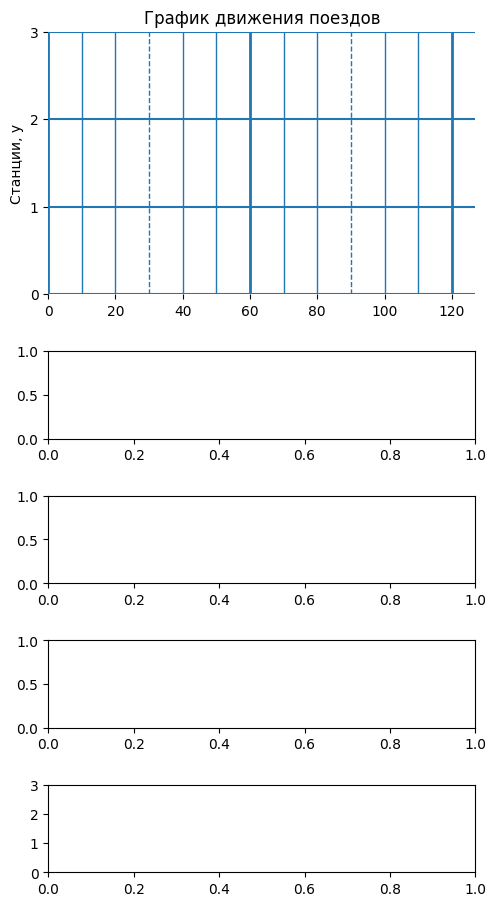

In [ ]:
# Графики занятости ресурсов
def show_res_busy(ax, x_max, title, resType, df_log_queue):

    ax.set_title(title)
    ax.set_xlim([0, x_max])
    ax.grid(True)
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    df = df_log_queue[(df_log_queue.dir == 0) & (df_log_queue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']+.2, df['sta']+.2], c='b', lw=5, alpha=0.75)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='b', ax=ax)
    df = df_log_queue[(df_log_queue.dir == 1) & (df_log_queue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']-.2, df['sta']-.2], c='r', lw=5, alpha=0.75)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='r', ax=ax)

    #df_sta = df_log_queue.drop_duplicates(subset=['sta'])
    #for index, row in df_sta.iterrows(): ax.axhline(y=row['sta'])
    #ax.get_yaxis().set_ticks(df_sta['sta'])

# Строим график движения поездов
def show_gts(train_schedule, log_queue, fs_width = 10, fs_height = 8, res_text = ['Way', 'ISc', 'IOt', 'IPr']):

    # Что отображаем
    ratios = []
    for r in res_text : ratios += [1]

    # Добавляем колонки в resQueue
    df_log_queue = pd.DataFrame(log_queue, columns=["res", "time", "dir", "sta", "cnt", "len"])
    df_log_queue = df_log_queue[(df_log_queue.cnt == 1)]
    df_log_queue['c'] = np.where(df_log_queue['dir'] == 1, 'r', 'g')

    # Добавим имена колонок
    df_train_schedule = pd.DataFrame(train_schedule, columns=["train", "sta", "time"])
    x_max = df_train_schedule['time'].max()  # Максимальное время

    # Создайте фигуру, содержащую одну ось
    fig, ax = plt.subplots(nrows=1+len(res_text), ncols=1, figsize=(fs_width, fs_height), gridspec_kw={'height_ratios': [3]+ratios})
    fig.tight_layout(h_pad=2)

    # Оси времени
    time_max = df_train_schedule['time'].max()
    ax[0].set_xlim([0, x_max])
    for i in range(10, time_max, 10):
        if i % 30 > 0: ax[0].axvline(x=i, linewidth=1)
    for i in range(30, time_max, 30):
        if i % 60 > 0: ax[0].axvline(x=i, linestyle='--', linewidth=1)
    for i in range(0, time_max, 60):
        ax[0].axvline(x=i, linestyle='-', linewidth=2)

    # Оси станций
    df_sta = df_train_schedule.drop_duplicates(subset=['sta'])
    plt.yticks(df_sta['sta'])
    ax[0].get_yaxis().set_ticks(df_sta['sta'])
    for index, row in df_sta.iterrows(): ax[0].axhline(y=row['sta'])

    # Подписи
    # plt.xlabel('Время, x')
    # plt.ylabel('Станции, y')
    # plt.title("График движения поездов")
    ax[0].set_ylabel('Станции, y')
    ax[0].set_title("График движения поездов")

    # Отключаем линии
    for sp in ['top', 'bottom', 'right', 'left']:
        ax[0].spines[sp].set_visible(False)

    # Рисуем нитки поездов
    df_train = df_train_schedule.groupby(['train']).first()
    for train, row in df_train.iterrows():
        t = df_train_schedule[(df_train_schedule['train'] == train)]
        y = t['sta']
        x = t['time']
        train_int = int(''.join(i for i in train if i.isdigit()))
        ax[0].plot(x, y, label=train_int, color='black' if train_int > 999 else 'red')
        # ax[0].text(row['time'], row['sta'], train)
        if train_int % 2 == 1:
            ax[0].text(row['time'] - 1, row['sta'] + .2, train_int)  # , rotation=-75.)
        else:
            ax[0].text(row['time'] - 1, row['sta'] - .2, train_int)  # , rotation=75.)
        # ax[0].legend()

    # Окно
    df_win = df_log_queue[(df_log_queue.res == 'Win') & (df_log_queue.len > 0)]
    ax[0].plot([df_win['time']-.1, df_win['time']+.1], [df_win['sta']+.2, df_win['sta']+1-.2], c='y', lw=5, alpha=0.25)

    i = 0
    for row in res_text:
        i +=1
        # Занятость пути перегона RWay
        if row == 'Way' : show_res_busy(ax[i], x_max, 'Занятость пути перегона RWay', 'Way', df_log_queue)

        # Интервала скрещения τс (тип III) 0,5 - ISc
        if row == 'ISc' : show_res_busy(ax[i], x_max, 'Интервала скрещения τс (тип III) 0,5 - ISc', 'ISc', df_log_queue)

        # Интервала попутного отправления поездов Iот (тип Х) - IOt
        if row == 'IOt' : show_res_busy(ax[i], x_max, 'Интервала попутного отправления Iот (тип Х) (3,25...7,25)', 'IOt', df_log_queue)

        # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3
        if row == 'IPr' : show_res_busy(ax[i], x_max, 'Интервала попутного прибытия Iпр (тип IX) 3,3...4,3', 'IPr', df_log_queue)

    ax[i].set_xlabel('Время, x')

    plt.show()

try:
    show_gts(train_schedule, log_queue, fs_width = 5, fs_height = 9, res_text = ['Way', 'ISc', 'IOt', 'IPr'])
except Exception as err:
    print(type(err))
    print(err.args)
    print(err)

## Построение графика движения поездов

In [ ]:
import simpy
import data
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import random

class MyPriorityResource(simpy.PriorityResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

class MyPreemptiveResource(simpy.PreemptiveResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

class TrainSchedule:

    # Инициализация
    def __init__(self, env, until=1440, sta_cnt = 4, t_i_ot = 6, t_i_pr = 5, t_i_sc = 2, schedule_data: data.Main = None):
        """
        :param env: среда моделирования
        :param sta_cnt: кол-во станций
        :param until: время моделирования в шагах
        :param t_i_ot: интервал попутного отправления
        :param t_i_pr: интервал попутного прибытия
        :param t_i_sc: интервал скрещения
        :param schedule_data: исходные данные
        """
        self.env = env
        self.schedule_data = schedule_data
        self.sta_cnt = sta_cnt
        self.train_schedule = []
        self.log_queue = []
        self.log_data = [] # Таблица графика движения (человекочитаемая)
        self.until = until # Предельная задержка
        self.res_win_s =  self.res_add(MyPreemptiveResource, i=1, n=sta_cnt - 1)
        self.res_way_s =  self.res_add(MyPreemptiveResource, i=2, n=sta_cnt - 1)
        self.res_trn_s =  self.res_add(MyPreemptiveResource, i=2, n=sta_cnt - 1)
        self.res_i_ot_s = self.res_add(MyPreemptiveResource, i=2, n=sta_cnt)
        self.res_i_pr_s = self.res_add(MyPreemptiveResource, i=2, n=sta_cnt)
        self.res_i_sc_s = self.res_add(MyPreemptiveResource, i=2, n=sta_cnt)
        self.t_i_ot = t_i_ot # Интервала попутного отправления Iот (тип Х) (3,25...7,25) - 8
        self.t_i_pr = t_i_pr # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3 - 5
        self.t_i_sc = t_i_sc # Интервала скрещения τс (тип III) 0,5 - 1
        self.run_proc()

    # Запускаем вспомогательные процессы
    def run_proc(self):

        # Лог занятия ресурсов
        self.env.process(self.queue_logger())

    # Генерация ресурсов
    def res_add(self, res, i, n):
        t = ()
        for d in range(i):
            l = []
            for r in range(n):
                l.append(res(self.env, capacity=1))
            t = t + (l,)
        return t

    # Сбор логов по ресурсу
    def queue_logger(self, t_step=1):
        res_list = [['Win', self.res_win_s],
                    ['Way', self.res_way_s],
                    ['Put', self.res_trn_s],
                    ['ISc', self.res_i_sc_s],
                    ['IOt', self.res_i_ot_s],
                    ['IPr', self.res_i_pr_s]]
        while True:
            # Каждый так добавляем
            for r, resList in enumerate(res_list):
                for i_dir, dir in enumerate(resList[1]):
                    for i_res, resItem in enumerate(dir):
                        item = (
                            resList[0],     # Ресурс (имя)
                            self.env.now,   # Текущее время
                            i_dir,          # Индекс направления
                            i_res,          # Индекс ресурса
                            resItem.count,      # Емкость очереди
                            len(resItem.queue)  # Дина очереди
                        )
                        self.log_queue.append(item)
            yield self.env.timeout(t_step)

    # Получение параметров движения
    def get_param(self, train, sta, mov, dir):

        sta = sta          # Станция отправления
        t_beg = 1          # Время на разгон
        t_end = 3          # Время на замедление

        if dir == 1:
            way = sta - 1      # Путь перегона
            sta_next = sta - 1 # Следующая станция
            way_next = way - 1 # Следующий путь перегона
            v = 0              # Встречное направление
            p = 1              # Попутное направление
        else:
            way = sta
            sta_next = sta + 1
            way_next = sta + 1
            v = 1
            p = 0

        t_mov = self.get_mov_from_data(train=train, sta=sta_next, dir=dir)  # Время движения

        res_win_s = self.res_win_s[0][way]  # Пусть перегона с окном
        res_way_v = self.res_way_s[v][way]  # Встречное направление
        res_way_p = self.res_way_s[p][way]  # Попутное направление
        res_trn_s = self.res_trn_s[p][way]

        # Интервал попутного отправления
        res_i_ot_p = self.res_i_ot_s[p][sta]  # Проверяем и занимаем

        # Интервал скрещения занимаем
        res_i_sc_next_v = self.res_i_sc_s[v][sta_next]  # Занимаем на следующей станции для встречных поездов
        res_i_sc_p = self.res_i_sc_s[p][sta]  # Проверяем

        # Интервал попутного прибытия
        res_i_pr_next_p = self.res_i_pr_s[p][sta_next]  # Занимаем на следующей станции для попутных поездов

        return (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
                res_win_s, res_trn_s, res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p)

    def get_mov_from_data(self, train, sta, dir):

        train_obj = next((t for t in self.schedule_data.trains if t.name == str(train)), None)

        if train_obj is None:
            raise ValueError('No such train: ' + str(train))

        # Найдём время движения к следующей станции
        # из-за особенности формата у нас данные о перегоне хранятся на предыдущей станции
        section_obj = self.schedule_data.sections[int(sta) - (1 if dir == 0 else 0)]
        if section_obj.runtimes.odd is None or section_obj.runtimes.even is None:
            raise ValueError('тупик ... ' + train)
        if dir == 0:
            mov = section_obj.runtimes.even.passenger if train_obj.type == 'passenger' else section_obj.runtimes.even.freight
        else:
            mov = section_obj.runtimes.odd.passenger if train_obj.type == 'passenger' else section_obj.runtimes.odd.freight
        return mov

    # Операция движения
    def driving(self, train, wait, prio, sta, mov, dir):

        (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
         res_win_s, res_trn_s, res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v,
         res_i_pr_next_p) = self.get_param(train=train, sta=sta, mov=mov, dir=dir)

        if t_mov < self.t_i_ot: raise ValueError(
            "Ограничение версии. Время хода меньше интервал попутного отправления")

        itrain = str(train).zfill(4) + f" ({sta}-{sta_next})"
        until = self.until
        while until  > 0:

            with res_i_ot_p.request(priority=prio) as req_i_ot_p:

                # Начало движения
                with (res_i_sc_p.request(priority=prio) as req_i_sc_p,          # Интервал скрещения, проверяем
                    res_way_p.request(priority=prio) as req_way_p,              # Попутное направления, проверяем
                    res_way_v.request(priority=prio) as req_way_v,              # Встречное направления, занимаем
                    res_i_sc_next_v.request(priority=prio) as req_i_sc_next_v,  # Интервал скрещения для встречных поездов, занимаем
                    res_win_s.request(priority=prio) as req_win_s,              # Окно на пути, проверяем
                    res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p   # Интервал попутного прибытия, проверяем и занимаем
                      ):
                    try:

                        # Ожидание отправления
                        put = self.env.now
                        print('Поезд № %s Ожидание отправления (req_i_ot_p, req_i_sc_p, req_win_s) в %s с prio=%s' % (itrain, self.env.now, prio))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, 'Ожидание отправления', None, None, None, None])

                        # Интервал попутного отправления, ждем
                        # Интервал скрещения, ждем
                        # Путь перегона, ждем
                        # Окно, ждем
                        yield req_i_ot_p & req_i_sc_p & req_way_p & req_win_s

                        # Интервал скрещения, освобождаем
                        res_i_sc_p.release(req_i_sc_p)

                        # Путь перегона, освобождаем
                        res_way_p.release(req_way_p)

                        # Окно, освобождаем
                        res_win_s.release(req_win_s)

                        # Попытка отправления
                        print('Поезд № %s Попытка отправления в %s' % (itrain, self.env.now))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка отправления", self.env.now, None, self.env.now - put, None])
                        t_delay_beg = self.env.now - put
                        beg = self.env.now

                        # Интервал попутного отправления, выполняем
                        yield self.env.timeout(self.t_i_ot)

                        # Интервал попутного отправления, освобождаем
                        res_i_ot_p.release(req_i_ot_p)

                        # Проезжаем
                        yield self.env.timeout(t_mov - self.t_i_ot)

                        # Путь перегона встречный, освобождаем
                        res_way_v.release(req_way_v)

                        # Ожидание прибытия
                        t_delay_end_put = self.env.now
                        print('Поезд № %s Ожидание прибытия (req_i_pr_next_p, req_win_s, req_way_p) в %s с priority=%s' % (itrain, self.env.now, prio))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Ожидание прибытия", beg, None, t_delay_beg, None])

                        # Интервал попутного прибытия, ждем
                        # Путь перегона попутный, ждем
                        # Окно, освобождаем-ждем-освобождаем
                        yield req_i_pr_next_p &  req_win_s & req_way_p

                        res_win_s.release(req_win_s)
                        print('Поезд № %s Попытка прибытия в %s' % (itrain, self.env.now))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка прибытия", beg, self.env.now, t_delay_beg, self.env.now - t_delay_end_put])
                        t_delay_end = self.env.now - t_delay_end_put
                        until = 0

                        # Регистрируем события
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Прибытие", beg, self.env.now, t_delay_beg, t_delay_end])
                        self.train_schedule.append([train, sta, beg])
                        self.train_schedule.append([train, sta_next, self.env.now])

                        # Ставим в очередь следующую операцию
                        if (sta_next < self.sta_cnt-1 and dir == 0) or (sta_next > 0 and dir == 1):
                            self.env.process(self.driving(train, wait=0, prio=prio, sta=sta_next, mov=mov, dir=dir))

                        # Завершаем интервалы:
                        # Интервал скрещения
                        # Интервал попутного прибытия
                        with (res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p):

                            # Интервал скрещения следующий встречный, выполняем
                            yield self.env.timeout(self.t_i_sc)

                            # Интервал скрещения следующий встречный, освобождаем
                            res_i_sc_next_v.release(req_i_sc_next_v)

                            # Интервал попутного прибытия, выполняем
                            yield self.env.timeout(self.t_i_pr - self.t_i_sc)

                    except simpy.Interrupt as interrupt:
                        by = interrupt.cause.by
                        usage = self.env.now - interrupt.cause.usage_since
                        until -= usage
                        print(f'{itrain} Вытеснение операции {by} at {self.env.now} after {usage}')
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Вытеснение", None, None, None, None])

    # Поезд
    def train(self, train, wait, prio=None, sta = None, mov = None, dir = None):
        """
        :param train: id поезда
        :param wait: время отправления
        :param dir: направление 0-чётное, 1-нечётное
        :param prio: приоритет
        :param sta: станция отправления
        :param mov: время движения по первому перегону
        :return:
        """

        if mov is None:
            raise ValueError("не задано время движения")
        if sta is None:
            raise ValueError("не задана станция")

        yield self.env.timeout(wait) # Время отправления поезда
        for s in range(self.sta_cnt-1, 0, -1) if dir == 1 else range(self.sta_cnt-1):
            if s >= sta and dir == 0 or s <= sta and dir == 1:
                print(f"train: {train}")
                op1 = self.env.process(self.driving(train, wait=0, prio=prio, sta=s, mov=mov, dir=dir))
                break

    # Окно
    def window(self, way, wait, dur):
        if way > self.sta_cnt-1: raise ValueError(
            'Не верно указан путь перегона для "Окна"')
        yield self.env.timeout(wait)
        res = self.res_win_s[0][way]
        res0 = self.res_way_s[0][way]
        res1 = self.res_way_s[1][way]
        print(self.env.now, 1)
        with (res.request(priority=-1) as req,
            res0.request(priority=-1) as req0,
            res1.request(priority=-1) as req1):

            yield self.env.timeout(dur)

## Тестовые данные для прогноза

### Исходные данные из кода

In [ ]:
# Временная заглушка если модуль data недоступен
class DataStub:
    class Main:
        def __init__(self):
            self.trains = []
            self.sections = []
            self.begin = None
            self.end = None

    class DirectionTime:
        def __init__(self, passenger, freight):
            self.passenger = passenger
            self.freight = freight

    class Runtime:
        def __init__(self, passenger_time, freight_time):
            self.even = DataStub.DirectionTime(passenger_time, freight_time)
            self.odd = DataStub.DirectionTime(passenger_time, freight_time)

    class Section:
        def __init__(self, id, name, passenger_time=10, freight_time=15, is_end=False):
            self.id = id
            self.name = name
            self.runtimes = DataStub.Runtime(passenger_time, freight_time)
            self.end = is_end

    class Train:
        def __init__(self, id, dir, name, type, control_points=None):
            self.id = id
            self.dir = dir
            self.name = name
            self.type = type
            self.controlPoints = control_points or []

    class ControlPoints:
        def __init__(self, station_id, in_time=None, out_time=None):
            self.stationId = station_id
            self.arrival = in_time
            self.departure = out_time
            setattr(self, 'in', in_time)
            setattr(self, 'out', out_time)

# Используем заглушку
data = DataStub()

def create_test_schedule_data(sta_count, trains_list):
    """Создает тестовые данные расписания"""

    def get_train_type(train_id):
        return "freight" if 1000 <= train_id <= 5999 else "passenger"

    def create_train(train_id, station_id, out_time):
        """Создает поезд с контрольными точками"""
        cp = data.ControlPoints(station_id, out_time=out_time)
        return data.Train(
            id=train_id,
            dir=train_id % 2,
            name=str(train_id),
            type=get_train_type(train_id),
            control_points=[cp]
        )

    # Основной объект расписания
    schedule_data = data.Main()
    schedule_data.begin = datetime.datetime(2025, 9, 25, 0, 0, 0)
    schedule_data.end = datetime.datetime(2025, 9, 26, 0, 0, 0)

    # Создаем перегоны
    n = sta_count
    schedule_data.sections = [
        data.Section(id=i, name=str(i), is_end=(i == n-1))
        for i in range(n)
    ]

    # Создаем поезда
    trains_config = trains_list

    schedule_data.trains = [
        create_train(train_id, station_id, out_time)
        for train_id, station_id, out_time in trains_config
    ]

    return schedule_data

# Выведи тестовые данные

# Создаем перегоны и поезда
sta_count = 5 # количество перегонов
trains_list = [
    (101, sta_count-1, datetime.datetime(2025, 9, 25, 0, 30, 0)),
    (2001, sta_count-1, datetime.datetime(2025, 9, 25, 0, 0, 0)),
    (102, 0, datetime.datetime(2025, 9, 25, 0, 30, 0)),
    (2002, 0, datetime.datetime(2025, 9, 25, 0, 0, 0))
]

schedule_data = create_test_schedule_data(sta_count, trains_list)

Begin: 2025-09-25 00:00:00
End: 2025-09-26 00:00:00

sections:
Section id: 0, End: False
  even: - passenger: 10, freight: 15
  odd:  - passenger: 10, freight: 15
Section id: 1, End: False
  even: - passenger: 10, freight: 15
  odd:  - passenger: 10, freight: 15
Section id: 2, End: False
  even: - passenger: 10, freight: 15
  odd:  - passenger: 10, freight: 15
Section id: 3, End: False
  even: - passenger: 10, freight: 15
  odd:  - passenger: 10, freight: 15
Section id: 4, End: True
  even: - passenger: 10, freight: 15
  odd:  - passenger: 10, freight: 15

trains:
 id: 101, dir: 1, name: 101, type: passenger
    1. stationId: 4, in: ---, out: 2025-09-25 00:30:00
 id: 2001, dir: 1, name: 2001, type: freight
    1. stationId: 4, in: ---, out: 2025-09-25 00:00:00
 id: 102, dir: 0, name: 102, type: passenger
    1. stationId: 0, in: ---, out: 2025-09-25 00:30:00
 id: 2002, dir: 0, name: 2002, type: freight
    1. stationId: 0, in: ---, out: 2025-09-25 00:00:00


### Исходные данные из json

In [ ]:
import json
from datetime import datetime

class DataStub:
    class Main:
        def __init__(self):
            self.trains = []
            self.sections = []
            self.begin = None
            self.end = None

    class DirectionTime:
        def __init__(self, passenger, freight):
            self.passenger = passenger
            self.freight = freight

    class Runtime:
        def __init__(self, odd_data=None, even_data=None):
            self.even = DataStub.DirectionTime(0, 0)
            self.odd = DataStub.DirectionTime(0, 0)
            if odd_data:
                self.odd = DataStub.DirectionTime(odd_data.get('passenger', 0), odd_data.get('freight', 0))
            if even_data:
                self.even = DataStub.DirectionTime(even_data.get('passenger', 0), even_data.get('freight', 0))

    class Section:
        def __init__(self, id, name, runtimes=None, is_end=False):
            self.id = id
            self.name = name
            self.runtimes = runtimes or DataStub.Runtime()
            self.end = is_end

    class Train:
        def __init__(self, id, dir, name, type, control_points=None):
            self.id = id
            self.dir = dir
            self.name = name
            self.type = type
            self.controlPoints = control_points or []

    class ControlPoint:
        def __init__(self, station_id, in_time=None, out_time=None):
            self.stationId = station_id

            # Логика для arrival и departure:
            # arrival - это время прибытия (in_time)
            # departure - это время отправления (out_time)
            self.arrival = in_time
            self.departure = out_time

            # Если arrival не задан, но есть departure, используем departure как arrival
            if self.arrival is None and self.departure is not None:
                self.arrival = self.departure

            # Если departure не задан, но есть arrival, используем arrival как departure
            if self.departure is None and self.arrival is not None:
                self.departure = self.arrival

            # Добавляем атрибуты 'in' и 'out' для совместимости
            setattr(self, 'in', self.arrival)
            setattr(self, 'out', self.departure)

def parse_datetime(time_str):
    """Парсит строку времени в объект datetime"""
    if not time_str:
        return None
    return datetime.fromisoformat(time_str.replace('Z', '+00:00'))

def load_schedule_from_json(file_path):
    """Загружает расписание из JSON файла в структуру DataStub"""

    # Читаем JSON файл
    with open(file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    # Создаем основной объект
    schedule_data = DataStub.Main()
    schedule_data.begin = parse_datetime(json_data.get('begin'))
    schedule_data.end = parse_datetime(json_data.get('end'))

    # Обрабатываем секции
    for section_data in json_data.get('sections', []):
        runtimes_data = section_data.get('runtimes', {})
        runtimes = DataStub.Runtime(
            odd_data=runtimes_data.get('odd'),
            even_data=runtimes_data.get('even')
        )

        section = DataStub.Section(
            id=int(section_data.get('id')),
            name=section_data.get('name'),
            runtimes=runtimes,
            is_end=section_data.get('end', False)
        )
        schedule_data.sections.append(section)

    # Обрабатываем поезда
    for train_data in json_data.get('trains', []):
        control_points = []

        for cp_data in train_data.get('controlPoints', []):
            cp = DataStub.ControlPoint(
                station_id=int(cp_data.get('stationId')),
                in_time=parse_datetime(cp_data.get('in')),
                out_time=parse_datetime(cp_data.get('out'))
            )
            control_points.append(cp)

        train = DataStub.Train(
            id=int(train_data.get('id')),
            dir=train_data.get('dir'),
            name=train_data.get('name'),
            type=train_data.get('type'),
            control_points=control_points
        )
        schedule_data.trains.append(train)

    return schedule_data

# Загружаем данные из файла
file_path = 'schedule_training.json'
schedule_data = load_schedule_from_json(file_path)

### Что в исходных данных?

In [ ]:

# Выводим информацию
print(f"Begin: {schedule_data.begin}")
print(f"End: {schedule_data.end}")

# Выводим информацию о всех перегонах
print("\nsections:")
for i, section in enumerate(schedule_data.sections):
    print(f"Section id: {section.id}, End: {section.end}")
    print(f"  even: - passenger: {section.runtimes.even.passenger}, freight: {section.runtimes.even.freight}")
    print(f"  odd:  - passenger: {section.runtimes.odd.passenger}, freight: {section.runtimes.odd.freight}")

# Выводим информацию о всех поездах
print("\ntrains:")
for train in schedule_data.trains:
    print(f" id: {train.id}, dir: {train.dir}, name: {train.name}, type: {train.type}")
    for i, cp in enumerate(train.controlPoints):
        # Используем getattr для доступа к атрибутам с зарезервированными именами
        arrival = getattr(cp, 'in') if getattr(cp, 'in') else "---"
        departure = getattr(cp, 'out') if getattr(cp, 'out') else "---"
        print(f"    {i+1}. stationId: {cp.stationId}, in: {arrival}, out: {departure}")

Begin: 2023-07-19 00:00:00
End: 2023-07-19 23:59:00

sections:
Section id: 0, End: False
  even: - passenger: 10, freight: 13
  odd:  - passenger: 10, freight: 13
Section id: 1, End: False
  even: - passenger: 7, freight: 10
  odd:  - passenger: 7, freight: 10
Section id: 2, End: False
  even: - passenger: 10, freight: 13
  odd:  - passenger: 10, freight: 13
Section id: 3, End: False
  even: - passenger: 7, freight: 10
  odd:  - passenger: 7, freight: 10
Section id: 4, End: False
  even: - passenger: 7, freight: 9
  odd:  - passenger: 7, freight: 9
Section id: 5, End: False
  even: - passenger: 8, freight: 11
  odd:  - passenger: 8, freight: 11
Section id: 6, End: False
  even: - passenger: 7, freight: 10
  odd:  - passenger: 7, freight: 10
Section id: 7, End: False
  even: - passenger: 8, freight: 11
  odd:  - passenger: 8, freight: 11
Section id: 8, End: False
  even: - passenger: 7, freight: 10
  odd:  - passenger: 7, freight: 10
Section id: 9, End: False
  even: - passenger: 6, fre

### Запуск расчета

Поездов: 34
Станций: 12
Запускаем НЕЧЁТНЫЙ passenger поезд 100 с ожиданием 360 со станции З. Приоритет 100
Запускаем ЧЁТНЫЙ passenger поезд 101 с ожиданием 515 со станции Г. Приоритет 100 
Запускаем ЧЁТНЫЙ passenger поезд 103 с ожиданием 1080 со станции Г. Приоритет 100 
Запускаем НЕЧЁТНЫЙ passenger поезд 102 с ожиданием 1080 со станции З. Приоритет 100
Запускаем НЕЧЁТНЫЙ passenger поезд 702 с ожиданием 995 со станции З. Приоритет 100
Запускаем НЕЧЁТНЫЙ passenger поезд 700 с ожиданием 405 со станции З. Приоритет 100
Запускаем ЧЁТНЫЙ passenger поезд 701 с ожиданием 489 со станции Г. Приоритет 100 
Запускаем ЧЁТНЫЙ passenger поезд 703 с ожиданием 1164 со станции Г. Приоритет 100 
Запускаем ЧЁТНЫЙ freight поезд 3401 с ожиданием 613 со станции Г. Приоритет 1000 
Запускаем НЕЧЁТНЫЙ freight поезд 3402 с ожиданием 906 со станции З. Приоритет 1000
Запускаем ЧЁТНЫЙ freight поезд 3001 с ожиданием 0 со станции Г. Приоритет 1000 
Запускаем НЕЧЁТНЫЙ freight поезд 3002 с ожиданием 0 со станции З. Пр

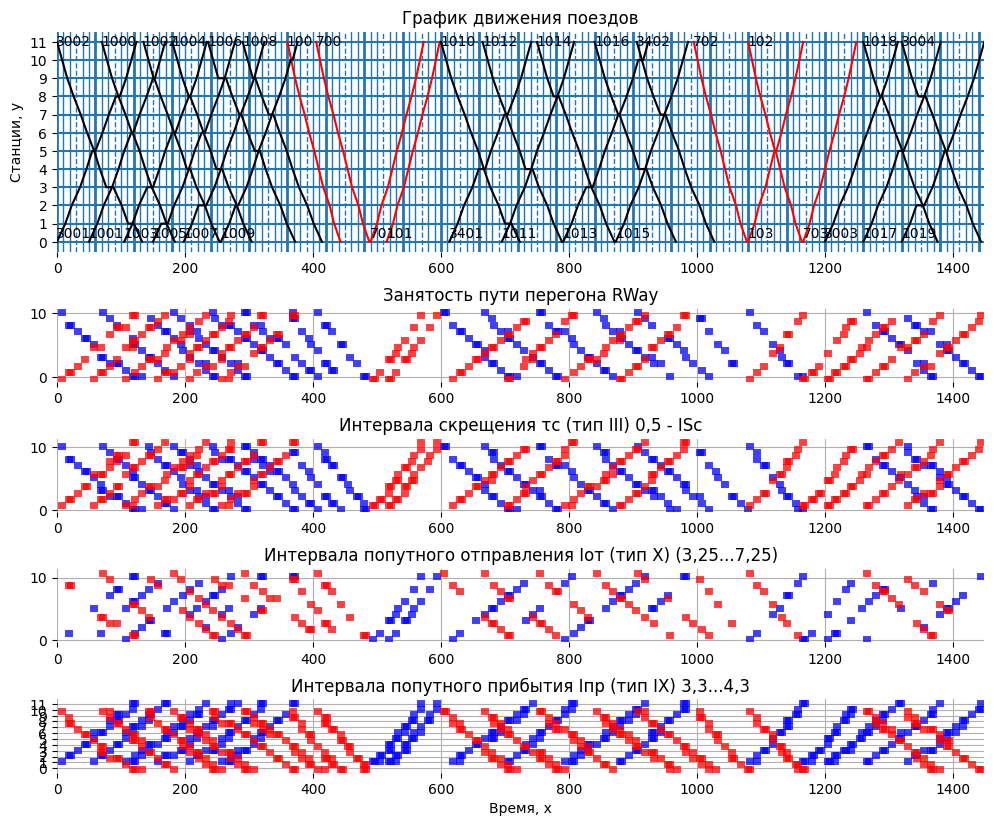

In [ ]:
# Создаем тестовые данные
main = schedule_data
print(f"Поездов: {len(main.trains)}")
print(f"Станций: {len(main.sections)}")

# Создаем среду моделирования
env = simpy.Environment()

# Устанавливаем время моделирования
until = 3600

# Получаем количество станций
section_count = len(main.sections)

# Инициализируем TrainSchedule с тестовыми данными
ts = TrainSchedule(
	env=env,
	sta_cnt=section_count,
	schedule_data=main,
 	until=until
)

for t in main.trains:
	wait = int((t.controlPoints[0].departure - main.begin).total_seconds() / 60)
	# станция отправления
	section = main.sections[int(t.controlPoints[0].stationId)]
	train_int = ''.join(i for i in t.name if i.isdigit())
	prio = 100 if int(train_int) < 1000 or 6000 < int(train_int) < 8000 else 1000
	if t.dir == 0:
		mov = section.runtimes.even.freight if t.type == "freight" else main.sections[0].runtimes.even.passenger
		print(f"Запускаем ЧЁТНЫЙ {t.type} поезд {t.name} с ожиданием {wait} со станции {section.name}. Приоритет {prio} ")
		env.process(ts.train(train=t.name, wait=wait, dir=0, mov=mov, sta=section.id, prio=prio))
	else:
		# для нечётных берём предыдущую станцию для получения данных о длине участка
		prev_section = main.sections[int(t.controlPoints[0].stationId) - 1]
		mov = prev_section.runtimes.even.freight if t.type == "freight" else prev_section.runtimes.even.passenger
		print(f"Запускаем НЕЧЁТНЫЙ {t.type} поезд {t.name} с ожиданием {wait} со станции {section.name}. Приоритет {prio}")
		env.process(ts.train(train=t.name, wait=wait, dir=1, mov=mov, sta=section.id, prio=prio))

# Запускаем simulation
env.run(until=until)

# Выводим результаты
print("Лог данных:")
for log in ts.log_data: print(log)

# Строим график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 10, fs_height = 8)

## Интервала скрещения τс (тип III) 0,5

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=580
ts = TrainSchedule(env = env, sta_cnt = 3, until=until)

# Интервал скрещения
#t2001 = env.process(ts.train1(train=2001, wait=5, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))
#или
t2001 = env.process(ts.train(train=2001, wait=0))
t2002 = env.process(ts.train(train=2002, wait=1, mov=25))

# Не работает если отправить в одно время
#t2001 = env.process(ts.train1(train=2001, wait=0, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## Интервала попутного отправления Iот (тип Х) (3,25...7,25)

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=360
ts = TrainSchedule(env = env, sta_cnt = 3, until = until)

# Интервал попутного отправления
t2001 = env.process(ts.train(train=2001, wait=0, prio=2001))
t2003 = env.process(ts.train(train=2003, wait=1, prio=2003))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## Интервала попутного прибытия Iпр (тип IX) 3,3...4,3

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=360
ts = TrainSchedule(env = env, sta_cnt = 3, until=until)

# Интервал попутного прибытия
t2002 = env.process(ts.train(train=2002, wait=0, mov=30))
t2004 = env.process(ts.train(train=2004, wait=10, mov=15))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)
q = pd.DataFrame(ts.log_data, columns=["train", "sta", "sta_n", "prio", "put", "oper","beg", "end", "d_beg", "d_end"])
q

## Обгоны

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 7)

# Приоритеты поездов
# Не можем обогнать поезд. 102 должен обогнать 2004
env.process(ts.train(train=2001, wait=0))
env.process(ts.train(train=2003, wait=30))
env.process(ts.train(train=101, wait=69))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, fs_width = 8, fs_height = 8, res_text = ['IOt', 'IPr'])
#ts.log_queue
#pd.DataFrame(log_data, columns=["train", "sta", "sta_n", "put", "beg", "end", "d_beg", "d_end"])

## Много поездов

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=560
ts = TrainSchedule(env = env, sta_cnt = 5, until=until)

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(60,90)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=120))
env.process(ts.train(train=103, wait=240))
env.process(ts.train(train=102, wait=120))
env.process(ts.train(train=104, wait=240))

# Выполняем расчет
env.run(until=560)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 8, 8, res_text = ['Way'])

ValueError: не задано время движения

## Много поездов и окно

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=560
ts = TrainSchedule(env = env, sta_cnt = 5, until=until)

# окно
env.process(ts.window(way=2, wait=240, dur=60))

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(60,90)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=120))
env.process(ts.train(train=103, wait=240))
env.process(ts.train(train=102, wait=120))
env.process(ts.train(train=104, wait=240))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 8, 8, res_text = ['Way'])